# Import Data

In [10]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize


from sklearn.decomposition import PCA

In [11]:
import seaborn as sns
sns.set()

In [12]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None,
                           include_values=True, xticks_rotation='horizontal', values_format=None,
                           cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [13]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [14]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [15]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [16]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [17]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = []

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0   
    
    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

In [18]:
#df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/binary/wnt_rest.xlsx")
df = pd.read_excel("/Users/michaelzhang/Desktop/MB_molec/mb_t1_t2_3way.xlsx")

# NN1 -> NN2

In [19]:
df

,molecular,molec_id,sex,dx_date,age,alive,os,pfs,seg_id,t1_log-sigma-1-mm-3D_firstorder_10Percentile,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,shh,BO_PF-MB_F_0007,F,2000-05-05 00:00:00,79.0,NaN,33,NaN,BO_PF-MB_F_0007_,-14.446979,...,1.973686,0.000808,1027.170040,0.297042,0.562429,1220.949377,0.000601,7.518529,0.134000,5335.217376
1,wnt,BO_PF-MB_F_0008,F,2006-01-05 00:00:00,90.0,Alive,30,NaN,BO_PF-MB_F_0008_,-11.965873,...,0.243711,0.005756,344.000989,0.340258,0.604408,481.129194,0.004316,7.318544,0.252624,209.948818
2,wnt,BO_PF-MB_F_0010,F,2000-08-16 00:00:00,76.0,Alive,92,NaN,BO_PF-MB_F_0010_,-15.311574,...,0.049205,0.000786,4051.276393,0.385322,0.644380,1826.940136,0.000552,8.163314,0.350257,66.167310
3,group3,BO_PF-MB_F_0015,F,2001-01-25 00:00:00,121.0,Alive,84,NaN,BO_PF-MB_F_0015_,-6.059545,...,3.112323,0.003300,481.319732,0.321953,0.586631,463.640209,0.002341,7.438314,0.129236,2106.125227
4,shh,BO_PF-MB_F_0017,F,2004-06-06 00:00:00,27.0,Alive,44,NaN,BO_PF-MB_F_0017_,-25.161749,...,0.094180,0.001028,1305.932045,0.382523,0.642779,1897.521463,0.000611,7.748172,0.291049,174.711614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,wnt,UT_PF-MB_M_0046,M,2015-01-24 00:00:00,172.0,Alive,39,NaN,UT_PF-MB_M_0046_,-16.559532,...,2.395014,0.001504,1891.628493,0.324298,0.589271,825.808563,0.001061,7.623581,0.181374,2622.388341
259,group3,UT_PF-MB_M_0047,M,2014-07-31 00:00:00,74.0,Alive,66,NaN,UT_PF-MB_M_0047_,-34.380056,...,0.624603,0.001676,1620.801636,0.323449,0.587494,651.778314,0.001052,7.619742,0.242852,478.635109
260,shh,UT_PF-MB_M_0048,M,2012-09-06 00:00:00,14.0,Alive,88,NaN,UT_PF-MB_M_0048_,-32.209457,...,2.016422,0.000795,3300.903006,0.325372,0.588549,1307.124424,0.000533,7.851386,0.205148,2879.261041
261,group3,UT_PF-MB_U_0034,F,2002-08-30 00:00:00,143.0,NaN,169,NaN,UT_PF-MB_U_0034_,-39.876621,...,0.015174,0.000513,3233.062155,0.397133,0.654572,4015.555125,0.000395,8.142065,0.366695,70.699119


In [20]:
first_target = df["molecular"]

In [21]:
first_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [22]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/MB_molec/reduced_molec.xlsx")

In [23]:
reduced_features_list = reduced_features.loc[reduced_features['group3_rest'].isnull() == False, ['group3_rest']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [24]:
first_target = first_target.map(dict(wnt = 0, shh = 0, group3 = 1)) #, type4 = 1))

In [25]:
first_features = df[reduced_features_list]

In [26]:
sex_binarized = first_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

first_features['sex'] = sex_binarized

<ipython-input-26-7abfed4242db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_features['sex'] = sex_binarized


In [27]:
first_features.head()

,sex,age,t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis,t1_log-sigma-3-mm-3D_firstorder_Median,t1_log-sigma-3-mm-3D_glcm_ClusterProminence,t1_log-sigma-3-mm-3D_glrlm_LowGrayLevelRunEmphasis,t1_log-sigma-5-mm-3D_glszm_GrayLevelVariance,t1_original_glszm_LargeAreaHighGrayLevelEmphasis,t1_original_glszm_LargeAreaLowGrayLevelEmphasis,t1_original_shape_Flatness,...,t1_wavelet-HHH_firstorder_Skewness,t1_wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis,t1_wavelet-HHL_glcm_ClusterProminence,t1_wavelet-LHH_firstorder_Median,t2_log-sigma-5-mm-3D_glcm_Imc2,t2_original_glcm_Idmn,t2_wavelet-LLL_firstorder_Median,t2_wavelet-HHH_firstorder_Skewness,t2_original_firstorder_Kurtosis,t2_wavelet-LLL_firstorder_TotalEnergy
0,0,79.0,0.009914,-12.089270,245.327427,0.019084,8.022161,2.602223e+07,85.552436,0.682624,...,0.042880,148622800.5,10.954663,0.018068,0.946161,0.996956,596.806751,-0.105871,4.894468,8.990875e+09
1,0,90.0,0.102841,-11.671423,12.795038,0.233604,2.187500,2.326738e+06,137.520927,0.669803,...,-0.065284,11673338.0,9.833085,-0.008537,0.979155,0.994937,642.043998,0.058554,3.931588,1.608287e+09
2,0,76.0,0.003729,-8.239284,493.668269,0.023936,4.982857,4.948329e+06,93.391301,0.695603,...,-0.008528,579684278.5,131.136413,-0.005812,0.976864,0.995178,700.333415,-0.008438,4.711055,1.686390e+10
3,0,121.0,0.031691,2.331270,21.102373,0.101722,1.580247,5.009737e+06,5158.876996,0.840785,...,-0.057422,111090330.0,2.704237,0.000723,0.941584,0.997205,469.224773,-0.003631,4.561519,2.620126e+09
4,0,27.0,0.005969,-26.768108,1069.669898,0.023480,11.610684,2.622241e+06,12.818837,0.591087,...,-0.001338,147017414.7,83.538561,0.022156,0.960911,0.996636,494.254206,-0.205003,8.391971,3.132893e+09


In [28]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, 
                                                   test_size = 0.25, random_state = 42)

In [29]:
y_train_1.value_counts()

1    112
0     85
Name: molecular, dtype: int64

In [30]:
y_test_1.value_counts()

1    42
0    24
Name: molecular, dtype: int64

In [31]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['molecular'] == 0]
first_X_1 = first_X[first_X['molecular'] == 1]
#first_X_2 = first_X[first_X['molecular'] == 2]

In [32]:
upsampled_0 = resample(first_X_0, replace = True, n_samples = len(first_X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, first_X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [33]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]

In [34]:
y_train_1.value_counts()

1    112
0    112
Name: molecular, dtype: int64

In [35]:
y_train_bin = label_binarize(y_train_1, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test_1, classes = [0, 1, 2])

y_train_1 = y_train_bin[:, 1]
y_test_1 = y_test_bin[:, 1]

In [36]:
names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

# NN1: group3_rest, decomposed from 3way

In [37]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = names)

X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = names)

In [38]:
nn_seq_1_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_seq_1_grid = GridSearchCV(estimator=nn_seq_1_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [39]:
nn_seq_1_grid.fit(X_train_1, y_train_1)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [40]:
print(nn_seq_1_grid.best_params_)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


In [41]:
nn_seq_1_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = nn_seq_1_model.predict(X_test_1)

In [42]:
print("Accuracy Score: " + str(accuracy_score(y_test_1, y_pred_1)))
#print("Specificity Score: " + str(specificity_score(y_test_1.to_numpy(), y_pred_1)))
print("Precision: " + str(precision_score(y_test_1, y_pred_1)))
print("Recall: " + str(recall_score(y_test_1, y_pred_1)))
print("F1 Score: " + str(f1_score(y_test_1, y_pred_1)))

#print("PPV Score: " + str(positive_pv_score(y_test_1.to_numpy(), y_pred_1)))
#print("NPV Score: " + str(negative_pv_score(y_test_1.to_numpy(), y_pred_1)))

Accuracy Score: 0.8787878787878788
Precision: 0.925
Recall: 0.8809523809523809
F1 Score: 0.9024390243902439


# NN2 - wnt_shh, decomposed from 3way

In [43]:
second_target = df["molecular"]

In [44]:
second_target.value_counts()

group3    154
shh        83
wnt        26
Name: molecular, dtype: int64

In [45]:
second_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)

In [46]:
second_target = second_target.map(dict(shh = 1, wnt = 0, group3 = -1)) ##, type4 = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [47]:
second_target.value_counts()

1    83
0    26
Name: molecular, dtype: int64

In [48]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [49]:
second_reduced_features_list = reduced_features.loc[reduced_features['wnt_shh'].isnull() == False, ['wnt_shh']].values.tolist()

In [50]:
second_reduced_features_list = [item for sublist in second_reduced_features_list for item in sublist]

In [51]:
second_features = second_features[second_reduced_features_list]

In [52]:
#sex_binarized = second_features['sex'].map(dict(M = 1, F = 0)).to_numpy()

#second_features['sex'] = sex_binarized

In [53]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [54]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['molecular'] == 0]
second_X_1 = second_X[second_X['molecular'] == 1]

In [55]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [56]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [57]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [58]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [59]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

In [60]:
nn_seq_2_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)

In [61]:
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

In [62]:
accuracy_score(y_test_2, y_pred_2)

0.9285714285714286

In [63]:
print("Accuracy Score: " + str(accuracy_score(y_test_2, y_pred_2)))
print("Specificity Score: " + str(specificity_score(y_test_2.to_numpy(), y_pred_2)))
print("Precision: " + str(precision_score(y_test_2, y_pred_2)))
print("Recall: " + str(recall_score(y_test_2, y_pred_2)))
print("F1 Score: " + str(f1_score(y_test_2, y_pred_2)))

print("PPV Score: " + str(positive_pv_score(y_test_2.to_numpy(), y_pred_2)))
print("NPV Score: " + str(negative_pv_score(y_test_2.to_numpy(), y_pred_2)))

Accuracy Score: 0.9285714285714286
Specificity Score: 0.8
Precision: 0.9565217391304348
Recall: 0.9565217391304348
F1 Score: 0.9565217391304348
PPV Score: 0.9565217391304348
NPV Score: 0.8


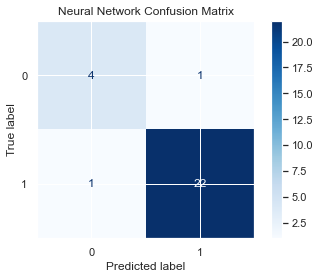

In [64]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

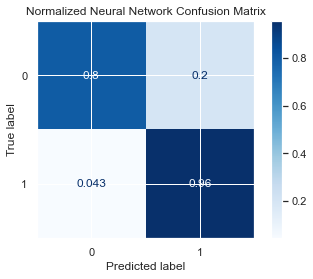

In [65]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# Testing

In [270]:
test_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1) 
test_target = df["molecular"]
second_target = df["molecular"] #MZ added
meta_target = df["molecular"] #MZ added

In [271]:
test_target = test_target.map(dict(wnt = 0, shh = 0, group3 = 1))
second_target = second_target.map(dict(wnt = 0, shh = 1, group3 = 0))

In [272]:
X_train, X_test, y_train, y_test = train_test_split(test_features, test_target, 
                                                    test_size = 0.25, random_state = 42)

In [273]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
meta_y_test = y_test.reset_index(drop = True) #MZ added

In [274]:
sex_binarized = X_test['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_test['sex'] = sex_binarized

In [275]:
X_test_reduced = X_test[reduced_features_list]

In [276]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

In [277]:
y_preds_after_first = nn_seq_1_model.predict(X_test_for_first)

In [278]:
accuracy_score(y_test, y_preds_after_first) #checks accuracy of stage1
#MZ added

0.8787878787878788

In [279]:
y_preds_after_first

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [280]:
group3_indices = np.where(y_preds_after_first == 1)
other_indices = np.where(y_preds_after_first != 1)

In [281]:
group3_preds = y_preds_after_first[group3_indices]
y_test_for_group3 = np.array(y_test)[group3_indices]

In [283]:
y_test_after_first_model = second_target #MZ added

In [284]:
X_test_after_first_model = X_test.iloc[other_indices].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices].reset_index(drop = True)

In [285]:
y_test_after_first_model

0     0
1     1
2     0
3     1
4     0
5     0
6     0
7     1
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    1
23    0
24    0
25    0
Name: molecular, dtype: int64

In [286]:
np.array(y_test) #ground truth

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [287]:
np.array(y_test_after_first_model) #leftover ground truth

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0])

In [288]:
X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]

In [289]:
X_test_after_first_model = second_scaler.transform(X_test_after_first_model)

In [290]:
#relabel the cohorts for 2nd stage; drop the identified group
y_test_after_first_model = np.array(y_test_after_first_model)
y_test_after_first_model[y_test_after_first_model == 2] = -1
#y_test_after_first_model[y_test_after_first_model == 1] = 1

In [291]:
y_preds_after_second = nn_seq_2_model.predict(X_test_after_first_model)

In [292]:
y_preds_after_second

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0])

In [293]:
accuracy_score(y_test_after_first_model, y_preds_after_second)

0.5384615384615384

In [294]:
y_preds_after_second[y_preds_after_second == 1] = 1
y_preds_after_second[y_preds_after_second == 0] = 0

In [295]:
y_test_after_first_model

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0])

In [296]:
y_test_after_first_model[y_test_after_first_model == 1] = 2
y_test_after_first_model[y_test_after_first_model == 0] = 1
y_test_after_first_model[y_test_after_first_model == -1] = 0

In [94]:
y_preds_overall = np.concatenate([y_preds_after_second, group3_preds])
y_test_overall = np.concatenate([y_test_after_first_model, y_test_for_group3])

In [95]:
accuracy_score(y_test_overall, y_preds_overall)

0.030303030303030304

In [96]:
sns.reset_orig()

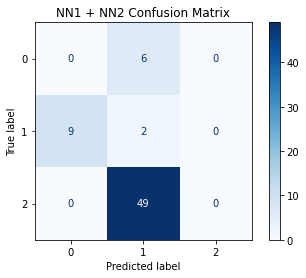

In [97]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('NN1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

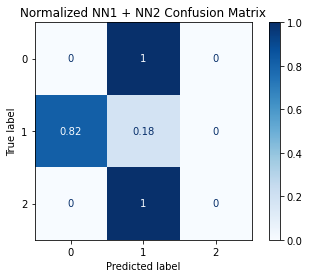

In [98]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Normalized NN1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

In [99]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

Specificities
0 0.85
1 0.0
2 1.0
Macro Avg : 0.6166666666666667
Micro Avg : 0.5151515151515151 

PPV/Precision
0 0.0
1 0.03508771929824561


ZeroDivisionError: division by zero

In [100]:
y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

In [ ]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
#    one_ppv = [] ##
#    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
#        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
#        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
#    bootstrapped_ppv_scores.append(one_ppv) ##
#    bootstrapped_npv_scores.append(one_npv) ##

In [ ]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

# Classification Results

In [ ]:
metadata_df = df['molecular']
target_for_table = df['molecular']

In [ ]:
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = target_for_table.map(dict(wnt = 0, shh = 1, group3 = 2)) ##, type4 = 2))

In [ ]:
#only used for metadata for which is train and which is test
X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

In [ ]:
X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

In [ ]:
X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

In [ ]:
final_df = X_for_table[['molecular', 'Set']]
features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
target_for_table = X_for_table['molecular']
target_for_table = target_for_table.map(dict(wnt = 0, shh = 1, group3 = 2)) ##, type4 = 2))

In [ ]:
X_table_reduced = features_for_table[reduced_features_list]

In [ ]:
sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()

X_table_reduced['sex'] = sex_binarized

In [ ]:
names = X_table_reduced.columns
X_table_for_first = first_scaler.transform(X_table_reduced)
X_table_for_first = pd.DataFrame(X_table_for_first, columns = names)

In [ ]:
y_probs_after_first_table = nn_seq_1_model.predict_proba(X_table_for_first)

In [ ]:
y_probs_after_first_table

In [ ]:
rf_1_table = pd.DataFrame(y_probs_after_first_table, columns = ['RF1 WNT Prob','RF1 Non-WNT Prob'])

In [ ]:
final_df['RF1 WNT Prob'] = rf_1_table['RF1 WNT Prob']
final_df['RF1 Non-WNT Prob'] = rf_1_table['RF1 Non-WNT Prob']

In [ ]:
y_preds_after_first_table = nn_seq_1_model.predict(X_table_for_first)
wnt_table_indices = np.where(y_preds_after_first_table == 0)
other_table_indices = np.where(y_preds_after_first_table != 0)

In [ ]:
y_table_for_wnt = np.array(y_preds_after_first_table)[wnt_table_indices]
X_table_after_first_model = features_for_table.iloc[other_table_indices]
X_table_after_first_model = X_table_after_first_model[second_reduced_features_list]
X_table_after_first_model_arr = second_scaler.transform(X_table_after_first_model)

In [ ]:
y_probs_after_second_table = nn_seq_2_model.predict_proba(X_table_after_first_model_arr)
y_preds_after_second_table = nn_seq_2_model.predict(X_table_after_first_model_arr)

In [ ]:
nn_2_table = pd.DataFrame(y_probs_after_second_table, columns = ['NN2 SHH Prob','NN2 Type 3/4 Prob'])

In [ ]:
X_table_after_first_model['NN2 SHH Prob'] = np.array(nn_2_table['NN2 SHH Prob'])
X_table_after_first_model['NN2 Type 3/4 Prob'] = np.array(nn_2_table['NN2 Type 3/4 Prob'])

In [ ]:
X_table_after_first_model = X_table_after_first_model[['NN2 SHH Prob', 'NN2 Type 3/4 Prob']]

In [ ]:
final_df = final_df.merge(X_table_after_first_model, how='left', left_index=True, right_index=True)

In [ ]:
def f(row):
    if row['RF1 Non-WNT Prob'] < row['RF1 WNT Prob']:
        val = 'wnt'
    else:
        if row['NN2 SHH Prob'] > row['NN2 Type 3/4 Prob']:
            val = 'shh'
        else:
            val = 'type 3/4'
    return val

In [ ]:
final_df['molec_id'] = df['molec_id']

In [ ]:
final_df['Pred Path'] = final_df.apply(f, axis = 1)

In [ ]:
final_df

In [ ]:
# Formatting
final_df.columns = ['True Molec', 'Set', 'RF1 Non-WNT Prob', 'RF1 WNT Prob',
                    'NN2 SHH Prob', 'NN2 Type 3/4 Prob', 'Molec Id', 'Pred Molec']
cols = final_df.columns.tolist()
cols = ['Molec Id', 'RF1 Non-WNT Prob', 'RF1 WNT Prob', 'NN2 SHH Prob', 'NN2 Type 3/4 Prob', 
        'Pred Molec', 'True Molec', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [ ]:
pd.set_option('display.max_rows', None)
final_df